In [21]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
df_train = pd.read_csv("../data/cleaned_train.csv")
df_test = pd.read_csv("../data/cleaned_test.csv")


In [23]:
print(df_train.shape)

(202944, 21)


In [24]:
df_X = df_train.drop(["Status"], axis=1)
df_y = df_train[["Status"]]

In [25]:
# Specify the same range for ExtraMedTest and ExtraAlcoholTest
lower_bound = -100
upper_bound = 100

# Check for values outside the specified range for both ExtraMedTest and ExtraAlcoholTest in df_train
out_of_range_both_train = df_train[(df_train['ExtraMedTest'] < lower_bound) | (df_train['ExtraMedTest'] > upper_bound) | 
                                   (df_train['ExtraAlcoholTest'] < lower_bound) | (df_train['ExtraAlcoholTest'] > upper_bound)]

# Check for values outside the specified range for both ExtraMedTest and ExtraAlcoholTest in df_test
out_of_range_both_test = df_test[(df_test['ExtraMedTest'] < lower_bound) | (df_test['ExtraMedTest'] > upper_bound) | 
                                 (df_test['ExtraAlcoholTest'] < lower_bound) | (df_test['ExtraAlcoholTest'] > upper_bound)]

In [26]:
# Calculate the number of rows with at least one feature out of range or both in df_train
num_rows_out_of_range_train = len(out_of_range_both_train)

# Calculate the number of rows with at least one feature out of range or both in df_test
num_rows_out_of_range_test = len(out_of_range_both_test)

# Print the number of rows with at least one feature out of range or both for df_train and df_test
print("Number of rows with at least one feature out of range or both in df_train:", num_rows_out_of_range_train)
print("Number of rows with at least one feature out of range or both in df_test:", num_rows_out_of_range_test)

Number of rows with at least one feature out of range or both in df_train: 54236
Number of rows with at least one feature out of range or both in df_test: 13303


In [27]:
train_X, test_X, train_y, test_y = train_test_split(
    df_X, df_y,
    shuffle=True,
    random_state=0,  
    test_size=0.2
)

train_y = train_y["Status"].values
test_y = test_y["Status"].values

print(f"train_X shape: {train_X.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"test_X shape: {test_X.shape}")
print(f"test_y shape: {test_y.shape}")

train_X shape: (162355, 20)
train_y shape: (162355,)
test_X shape: (40589, 20)
test_y shape: (40589,)


In [28]:
baseline_clf = LogisticRegression(
    penalty=None,             # No regularization
    class_weight="balanced",  # Because our training data is imbalanced
    max_iter=1_000,
    random_state=99           # Reproducible result
)

baseline_clf.fit(train_X, train_y)
pred_y = baseline_clf.predict(test_X)

In [29]:
baseline_performance_report = classification_report(test_y, pred_y)
print(f"'BASELINE MODEL PERFORMANCE'\n{baseline_performance_report}")

'BASELINE MODEL PERFORMANCE'
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     33494
           1       0.62      0.88      0.73      7095

    accuracy                           0.88     40589
   macro avg       0.80      0.88      0.83     40589
weighted avg       0.91      0.88      0.89     40589



In [30]:
for col in df_train.columns:
    if col == "Status":
        continue

    q1 = df_train[col].quantile(0.25)
    q3 = df_train[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Cap outliers
    df_train[col] = np.where(df_train[col] < lower_bound, lower_bound, df_train[col])
    df_train[col] = np.where(df_train[col] > upper_bound, upper_bound, df_train[col])

    

In [31]:

# scaler = StandardScaler()
# for col in df_train.columns:
#     if col == "Status":
#         continue

#     df_train[[col]] = scaler.fit_transform(df_train[[col]])
#     df_test[[col]] = scaler.fit_transform(df_test[[col]])


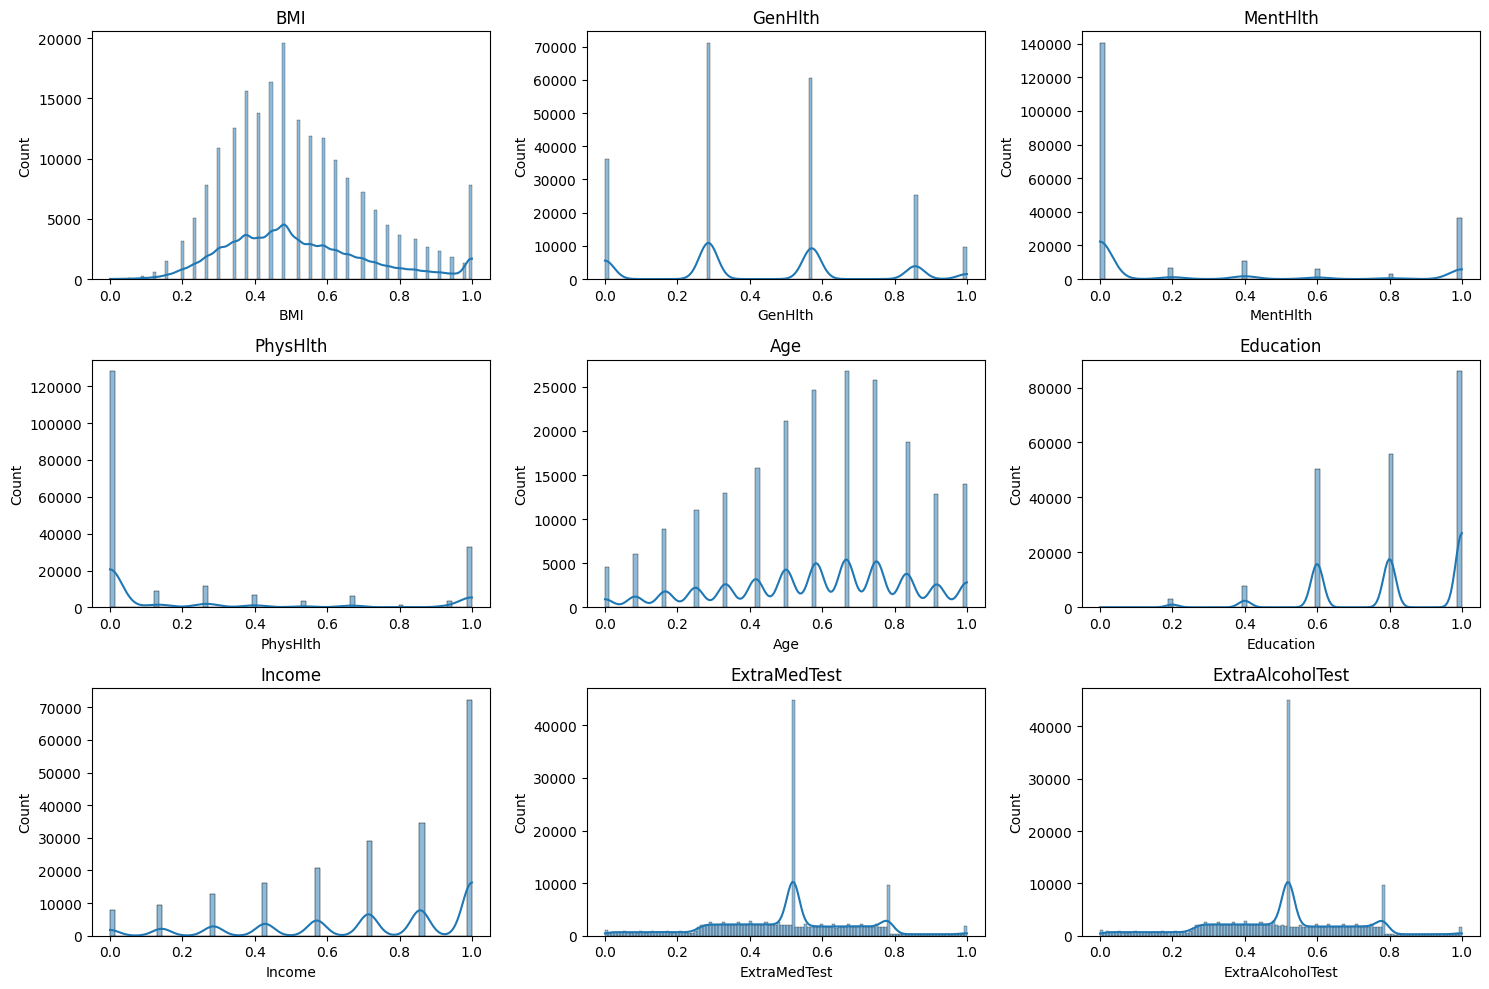

In [33]:
numerical_features = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income',
                      'ExtraMedTest', 'ExtraAlcoholTest']

scaler = MinMaxScaler()
df_train[numerical_features] = scaler.fit_transform(df_train[numerical_features])
df_test[numerical_features] = scaler.fit_transform(df_test[numerical_features])
# Plot histograms for numerical features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_train[feature], kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()

In [34]:
print(df_train.head())

   HighBP  HighChol       BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0     0.0       0.0  0.375000     1.0     0.0                   0.0   
1     0.0       0.0  0.517857     0.0     0.0                   0.0   
2     0.0       0.0  0.803571     1.0     0.0                   0.0   
3     0.0       1.0  0.767857     0.0     0.0                   0.0   
4     0.0       1.0  0.482143     0.0     0.0                   0.0   

   PhysActivity  Fruits  Veggies  HvyAlcoholConsump  ...  MentHlth  PhysHlth  \
0           1.0     0.0      1.0                0.0  ...       0.0       0.0   
1           1.0     1.0      1.0                0.0  ...       0.2       0.0   
2           1.0     1.0      1.0                0.0  ...       1.0       1.0   
3           1.0     1.0      1.0                0.0  ...       0.0       0.0   
4           1.0     0.0      1.0                0.0  ...       0.0       0.0   

   DiffWalk  Sex       Age  Education    Income  ExtraMedTest  \
0       0.0  0.0  0.583333 

In [35]:
print(df_train.isna().sum())

HighBP                  0
HighChol                0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
ExtraMedTest            0
ExtraAlcoholTest        0
Status                  0
dtype: int64


In [36]:
# Separate majority and minority classes
no_diabetes = df_train[df_train["Status"] == 0]
diabetes = df_train[df_train["Status"] == 1]

diabetes_upsampled = resample(
    diabetes,
    replace=True,
    n_samples=len(no_diabetes),
    random_state=0
)
    
# Combine majority class with upsampled minority class
df_train = pd.concat([no_diabetes, diabetes_upsampled])


In [37]:
status_counts = df_train['Status'].value_counts()

# Display the counts
print("Count of 0:", status_counts[0])
print("Count of 1:", status_counts[1])

Count of 0: 167313
Count of 1: 167313


In [38]:
print(df_train.shape)

(334626, 21)


In [39]:
df_X = df_train.drop(["Status"], axis=1)
df_y = df_train[["Status"]]

train_X, test_X, train_y, test_y = train_test_split(
    df_X, df_y,
    shuffle=True,
    random_state=0,  # Ensure reproducible results
    test_size=0.2
)

train_y = train_y["Status"].values
test_y = test_y["Status"].values

baseline_clf.fit(train_X, train_y)
pred_y = baseline_clf.predict(test_X)

print(f"'BASELINE MODEL PERFORMANCE'\n{baseline_performance_report}")
print(f"'NEW MODEL PERFORMANCE\n{classification_report(test_y, pred_y)}")

'BASELINE MODEL PERFORMANCE'
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     33494
           1       0.62      0.88      0.73      7095

    accuracy                           0.88     40589
   macro avg       0.80      0.88      0.83     40589
weighted avg       0.91      0.88      0.89     40589

'NEW MODEL PERFORMANCE
              precision    recall  f1-score   support

           0       0.87      0.88      0.88     33547
           1       0.88      0.87      0.88     33379

    accuracy                           0.88     66926
   macro avg       0.88      0.88      0.88     66926
weighted avg       0.88      0.88      0.88     66926



In [40]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 334626 entries, 0 to 93340
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HighBP                334626 non-null  float64
 1   HighChol              334626 non-null  float64
 2   BMI                   334626 non-null  float64
 3   Smoker                334626 non-null  float64
 4   Stroke                334626 non-null  float64
 5   HeartDiseaseorAttack  334626 non-null  float64
 6   PhysActivity          334626 non-null  float64
 7   Fruits                334626 non-null  float64
 8   Veggies               334626 non-null  float64
 9   HvyAlcoholConsump     334626 non-null  float64
 10  GenHlth               334626 non-null  float64
 11  MentHlth              334626 non-null  float64
 12  PhysHlth              334626 non-null  float64
 13  DiffWalk              334626 non-null  float64
 14  Sex                   334626 non-null  float64
 15  Age   

In [41]:
df_train.to_csv("../data/transformed_train.csv", index=False)
df_test.to_csv("../data/transformed_test.csv", index=False)
